# DeepFM Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.nn import MSELoss
from torch.optim import Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

from pytorch_common.util import set_device_name, \
                                get_device, \
                                LoggerBuilder

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

from torchviz import make_dot

<Figure size 432x288 with 0 Axes>

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
cpu = torch.device("cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.11.0'

In [9]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [10]:
set_seed(42)

## Carga de dataset

1. importamos los archivos de peliculas y ratings preprocesados prebiamente en mongodb:

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform=features_fn,
    target_transform=target_fn,
    device=cpu,
    filter_fn = lambda df: df[(df['user_movie_rating_year'] >= 2014) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102038 entries, 0 to 102037
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      102038 non-null  int64         
 1   user_seq                     102038 non-null  int64         
 2   user_movie_tags              102038 non-null  object        
 3   user_movie_rating            102038 non-null  int64         
 4   user_movie_rating_timestamp  102038 non-null  datetime64[ns]
 5   user_movie_rating_year       102038 non-null  int64         
 6   movie_id                     102038 non-null  int64         
 7   movie_seq                    102038 non-null  int64         
 8   movie_title                  102038 non-null  string        
 9   movie_genres                 102038 non-null  object        
 10  movie_for_adults             102038 non-null  bool          
 11  movie_original_language   

# Normalizar

**Pendiente:** Los ratings tiene qeu ser relativos al igual que en el baseline, es decir el usuario 1 puede puntuar todo como 5, todo le parece bien y el usaurio 2 es pesimista. pro eso necesitamso una medida relativa a la media de los ratings de cada usuario.

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-05-20 21:28:41,656 - INFO - Train: 69.48 % - Test: 13.53 %


## Definicion del modelo

In [13]:
params = Bunch({
    'lr': 0.0001,
    'lr_patience': 5,
    'epochs': 10,
    'embedding_size': 50,
    'units_per_layer': [50, 10],
    'dropout': 0.2,
    'n_workers': 24,
    'batch_size': 64,
    'features_n_values': [len(it) for it in dataset.features_uniques],
    'device': get_device()
})

In [14]:
train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True)
test_dl  = DataLoader(eval_set, params.batch_size, num_workers=params.n_workers,  pin_memory=True)

In [15]:
class MSELossFn(torch.nn.Module):
    def __init__(self, float_result=False): 
        super().__init__()
        self.__fn = MSELoss()
        self.__float_result = float_result

    def __flatten(self, values, label):
        if(len(values.shape) > 1):
            logging.debug(f'flatten {label} of shape {values.shape}')
            return values.squeeze(1)
        return values
        
    def forward(self, y_pred, y_true):
        y_pred, y_true = self.__flatten(y_pred, 'y_pred'), self.__flatten(y_true, 'y_true')

        loss = self.__fn(y_pred.float(), y_true.float())

        return loss.item() if self.__float_result else loss

In [16]:
model = ml.DeepFM(
    params.features_n_values,
    params.embedding_size,
    params.units_per_layer,
    params.dropout
).to(params.device)
# model

In [17]:
# make_dot(y_pred, params=dict(model.named_parameters()))

## Entrenamiento del modelo

<Figure size 720x432 with 1 Axes>

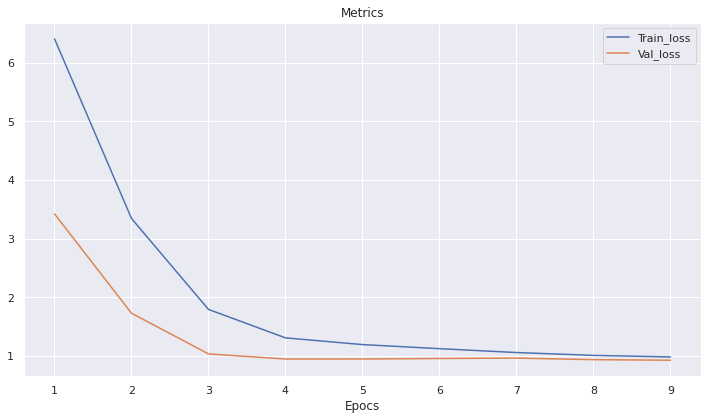

2022-05-20 21:29:47,529 - INFO - Save best model: ../weights/2022-05-20_21-29-47--experiment--epoch_10--val_loss_0.9187018275260925.pt


In [18]:
result = model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = MSELossFn(),
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr
    ),
    callbacks   = [
        Validation(
            test_dl,
            metrics = { 'val_loss': MSELossFn(float_result=True)},
            each_n_epochs=1
        ),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
        MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=1),
        SaveBestModel(metric='val_loss', path='../weights'),
        ReduceLROnPlateau(metric='val_loss', mode='max', patience=params.lr_patience)
    ]
)

In [20]:
PATH = '../weights/2022-05-20_21-29-47--experiment--epoch_10--val_loss_0.9187018275260925.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
deep_fm_predictor = ml.ModulePredictor(model)

In [22]:
observation = eval_set.features[100]

deep_fm_predictor.predict(observation[0].item(), observation[1].item()), eval_set.targets[100]

(tensor([3.0228]), tensor([5]))

In [23]:
validator = ml.Validator(
    n_samples  = 1000,
    batch_size = 10000,
    metrics    = [
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5))
    ],
    predictors = [deep_fm_predictor]
)

summary = validator.validate(eval_set)

summary.save('../metrics/deep_fm_predictor')

Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
summary = ml.ValidatorSummary.load('../metrics/deep_fm_predictor')

<Figure size 1440x360 with 2 Axes>

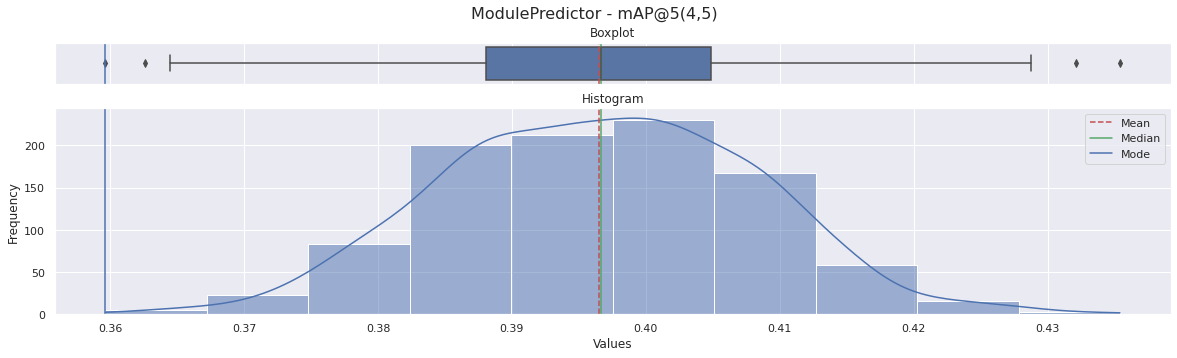


Metrics:



,"mAP@5(4,5)"
count,1000.000000
mean,0.396514
std,0.011638
min,0.359653
25%,0.388076
50%,0.396630
75%,0.404847
max,0.435401


<Figure size 1440x360 with 2 Axes>

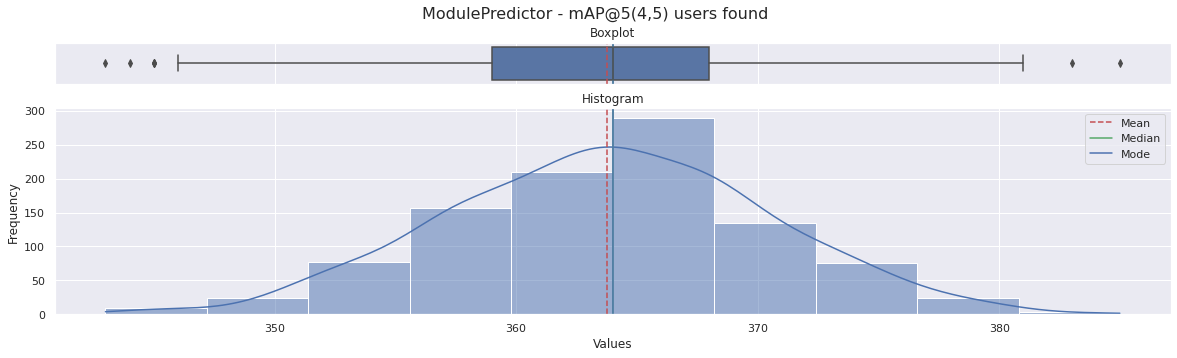


Metrics:



,"mAP@5(4,5) users found"
count,1000.000000
mean,363.764000
std,6.692615
min,343.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,385.000000


In [25]:
summary.plot(bins=10, show_table=True)